#### 사용자 행동인식 데이터 세트 (UCI HAR dataset)   
앙상블 방법을 통해 분류  
    1. voting (hard and soft)  
    2. bagging (랜덤포레스트)  
    3. boosting (XGBoost)  

   - voting 방식에서 선형회귀 + 서포트벡터 + k-최근접이웃. 3가지 결합함. 정확도는 hard & soft 둘다 0.9 이상.      
      

             
   - 랜덤포레스트 정확도 : 0.9237
   

   -  XGboost 정확도 : 0.9389

1. ### 데이터 전처리

In [130]:
import pandas as pd
import matplotlib.pyplot as plt

In [131]:
# 중복된 피쳐명 처리를 위한 함수 정의

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data = old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_nmae_df = new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 
        'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) if x[1] > 0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [102]:
# 학습 및 테스트 데이터를 DataFrame 으로 로딩하는 함수.

def get_human_dataset():
    # 각 데이터 파일은 공백으로 분리되어 있으므로 read_csv 에서 공백 문자를 sep로 할당
    feature_name_df = pd.read_csv('human_activity/UCI HAR Dataset/features.txt', sep='\s+' ,
                    header=None, names=['column_index', 'column_name'])
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame 생성
    new_feature_name_df = get_new_feature_name_df(feature_name_df)

    # DataFrame에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

    # 학습피처 데이터 세트와 테스트피처 데이터를 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('human_activity//UCI HAR Dataset/train/X_train.txt', sep='\s+', header=None, names=feature_name)
    X_test = pd.read_csv('human_activity//UCI HAR Dataset/test/X_test.txt', sep='\s+', header=None, names=feature_name)

    # 학습 레이블과 테스트 레이블 데이터를 DataFrame 으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('human_activity//UCI HAR Dataset/train/y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv('human_activity//UCI HAR Dataset/test/y_test.txt', sep='\s+', header=None, names=['action'])

    # 로드된 학습 / 테스트용 DataFrame을 모두 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [103]:
# 데이터셋 로드 및 spape 확인
X_train.shape , X_test.shape, y_train.shape, y_test.shape

((7352, 561), (2947, 561), (7352, 1), (2947, 1))

In [104]:
print('## 학습 피처 데이셋 info()')
print(X_train.info())

## 학습 피처 데이셋 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [105]:
#피쳐네임 관찰 #561개의 피쳐가 있으며 사람의 동작을 파악한 자료들을 통해. 어떤 동작인지(target) 예측 분류 하려함.
X_train.head(3)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118


In [106]:
y_train['action'].value_counts() # 1~6 까지 총 여섯개의 동작이 있다.
# y_train

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64

### 2. 1 DT 결정트리 이용 분류
    - 예측 정확도는 85%를 얻었다.
    - 파라메터 튜닝후 87% 로 상승
    - feature_importances_ 메서드를 통해 중요 피쳐를 시각화 한 결과 
        - 41번 피쳐인 tGravityAcc-mean()-X 값이 중요하다는 결론
        - x축방향의 중력가속도 최솟값 인듯 하다. 모션예측에서 X축방향으로 움직이려는 힘이라고 대강 생각해본다.

In [107]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt_clf =DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train, y_train)
pred =dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('결정트리 예측 정확도 : {0:.4f}'.format(accuracy))

print('DecisionTreeClassifier 기본 하이퍼 파라미터 :\n', dt_clf.get_params())

결정트리 예측 정확도 : 0.8548
DecisionTreeClassifier 기본 하이퍼 파라미터 :
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


gridsearchCV 하이퍼파라메터 튜닝

In [108]:
# gridsearchCV 이용 h파라메터 튜닝
from sklearn.model_selection import GridSearchCV
params = {
    'max_depth' : [6, 8, 10, 12, 16, 20, 24]
}
grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=3, verbose=1) #verbose는 뭐지
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치 : {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터 :', grid_cv.best_params_)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
GridSearchCV 최고 평균 정확도 수치 : 0.8473
GridSearchCV 최적 하이퍼 파라미터 : {'max_depth': 6}


In [109]:
# GridSearchCV 객체의 cv_result_ 속성을 DF로 생성
cv_results_df = pd.DataFrame(grid_cv.cv_results_)
cv_results_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.847251
1,8,0.837323
2,10,0.830111
3,12,0.827663
4,16,0.825352
5,20,0.828344
6,24,0.828344


In [110]:
# max_depth 와 min_sample_split 을 변경하여 튜닝

params = {
    'max_depth' : [6, 8, 12, 16, 20],
    'min_samples_split' : [16,24],
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=3, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치 : {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터 :', grid_cv.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
GridSearchCV 최고 평균 정확도 수치 : 0.8459
GridSearchCV 최적 하이퍼 파라미터 : {'max_depth': 8, 'min_samples_split': 16}


In [111]:
best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred1)
print('결정 트리 예측 정확도 : {0:.4f}'.format(accuracy))

결정 트리 예측 정확도 : 0.8717


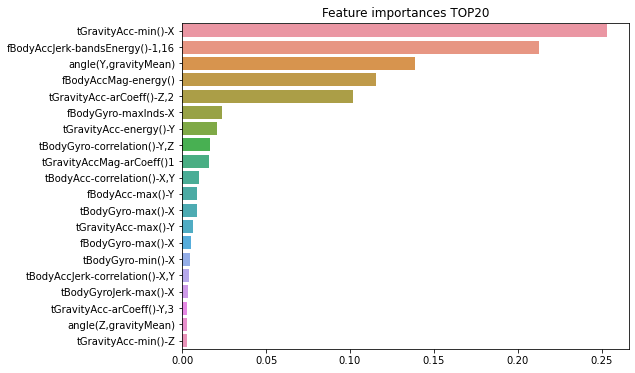

In [112]:
# 어떤 피쳐가 중요도를 갖는가? 시각화.  feature_importances_ 
import seaborn as sns 

ftr_importances_vlaues = best_df_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_vlaues, index=X_train.columns)
# 중요도 값 순으로 Series를 정렬
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature importances TOP20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

### 2.2 앙상블 클래시파이어, voting, bagging, boosting
1. soft & hard voting (로지스틱회귀, SVM, Knn 3가지 결합)
2. 랜덤포레스트 이용 bagging방식
3. XGBoost 이용 부스팅 방식

#### hard voting

In [113]:
# from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [114]:
lrc = LogisticRegression(max_iter=1000)
svc = SVC(probability=True)
knn = KNeighborsClassifier()

In [115]:
from sklearn.ensemble import VotingClassifier

voc = VotingClassifier(
    estimators=[('LRC',lrc), ('SVC', svc), ('KNN', knn)], voting='hard'   # 값을 튜플로 준다.
)

In [132]:
voc.fit(X_train, y_train)
voc_hard = voc.score(X_test, y_test)
voc.score(X_test, y_test)

# 0.9545~ score

0.9606379368849678

In [117]:
lrc.fit(X_train, y_train)
svc.fit(X_train, y_train)
knn.fit(X_train, y_train)
lrc.score(X_test, y_test), svc.score(X_test, y_test), knn.score(X_test, y_test)
# (0.9579233118425518, 0.9504580929759077, 0.9015948422124194) lrc, svc가 성능좀항. 
# knn이 좀 떨어져 그래도 90점?

(0.9613165931455717, 0.9504580929759077, 0.9015948422124194)

#### 소프트 보팅 (predic_proba)

In [118]:
lrc.predict_proba(X_test[:5])
svc.predict_proba(X_test[:5])
knn.predict_proba(X_test[:5])

array([[0. , 0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 0.2, 0.8, 0. ],
       [0. , 0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 0. , 1. , 0. ]])

lrc부분 상술

In [119]:
lrc.predict_proba(X_test[:5])
# 1 -6 번까지 6개 액션
# 5개 다 90퍼 이상 확률로 5번 액션

array([[3.95279959e-07, 8.15396274e-07, 1.46271409e-06, 1.54530732e-04,
        9.99788400e-01, 5.43958623e-05],
       [2.93254010e-06, 1.03273088e-06, 1.02250713e-07, 4.13834674e-02,
        9.58442370e-01, 1.70095366e-04],
       [5.14659640e-06, 4.87433045e-08, 3.13263415e-07, 7.53687004e-02,
        9.24489156e-01, 1.36635244e-04],
       [2.22682590e-06, 1.70310363e-07, 1.18593951e-07, 4.33537118e-02,
        9.56507303e-01, 1.36469502e-04],
       [2.91451094e-07, 2.15537761e-08, 2.33723333e-08, 6.82227475e-03,
        9.93166842e-01, 1.05471169e-05]])

In [120]:
lrc.predict(X_test[:5])

array([5, 5, 5, 5, 5], dtype=int64)

In [121]:
y_test.head() # 위 5개는 다 맞춤. 

,action
0,5
1,5
2,5
3,5
4,5


In [133]:
voc = VotingClassifier(
    estimators=[('LRC',lrc), ('SVC', svc), ('KNN', knn)], voting='soft'   # 값을 튜플로 준다.
)
voc.fit(X_train, y_train)
voc_soft = voc.score(X_test, y_test)
voc.score(X_test, y_test)
# 훈련 및 평가 점수는 0.9582626399728538

0.9602986087546658

### baggang - RandomforestClassifier

In [123]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import warnings 
warnings.filterwarnings('ignore')

In [134]:
rf_clf = RandomForestClassifier(random_state=2022)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
rf_accuracy = accuracy
print(f'랜덤포레스트 정확도 : {accuracy:.4f}')

랜덤포레스트 정확도 : 0.9237


### XGBoost 모델 부스팅방식

In [125]:
from xgboost import XGBClassifier
import numpy as np

XGboost 객체에서 fit 수행시 y 분류값을 0 ,1, 2 순서로 주기를 기대하여 오류 발생

target 값 1,2,3,4,5,6 을  0, 1, 2, 3, 4, 5 로 수정해 주고자   

np.unique(y_train) 및 y_train -1 , y_test -1 수행 

In [126]:
# np.unique(y_train)
y_train_end = y_train - 1
y_test_end = y_test -1

In [127]:
# y_train_end #  0~5 까지 6개의 값을 갖는다.
# y_test_end # 마찬가지 

In [128]:
#레이블인코더 False 사용여부 모델성능에 영향은 없으며, XGB수행시 나오는 사용자 경고를 제거한다
xgb = XGBClassifier(use_label_encoder=False)
xgb.fit(X_train, y_train_end)   # y_train_end 사용주의

[14:39:59] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [135]:
from sklearn.metrics import accuracy_score
pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test-1, pred)
xgb_accuracy = accuracy
print(f'XGboost 정확도 : {accuracy:.4f}')

XGboost 정확도 : 0.9389


In [145]:
# 분류별 정확도 비교
print(f'### 정확도 비교 ###\n1.1.voting_hard : {voc_hard:.4f}\n1.2.voting_soft : {voc_soft:.4f}\n2.Bagging방식 랜덤포레스트 : {rf_accuracy:.4f}\n3.Boosting방식 XGBoost : {xgb_accuracy:.4f}')

### 정확도 비교 ###
1.1.voting_hard : 0.9606
1.2.voting_soft : 0.9603
2.Bagging방식 랜덤포레스트 : 0.9237
3.Boosting방식 XGBoost : 0.9389
